# Compression

In [1]:
## Imports

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
from itertools import groupby
import scipy.misc
import scipy.signal
from scipy import ndimage
import time
import os
import cPickle
from matplotlib.colors import LogNorm
import sklearn.cluster

## Convert `tots.ipynb` notebook to an ordinary python script, so that it can be imported here

!jupyter nbconvert --to script tots.ipynb
import event_converter
import cluster_sizes
import tots
reload(event_converter)
reload(cluster_sizes)
reload(tots)
from event_converter import *
from cluster_sizes import *
from tots import *

print 'Done.'

[NbConvertApp] Converting notebook tots.ipynb to script
[NbConvertApp] Writing 14414 bytes to tots.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook cluster_sizes.ipynb to script
[NbConvertApp] Writing 14752 bytes to cluster_sizes.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

Done.


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook cluster_sizes.ipynb to script
[NbConvertApp] Writing 14752 bytes to cluster_sizes.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 7204 bytes to event_converter.py


<IPython.core.display.Javascript object>

Done.


<IPython.core.display.Javascript object>

Done.


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

591
591
662
460
592
694
692
2288
1
base 31512 1.01399421692
row_cluster 11866 29.855966568
zrle 10990 33.0231189728
lzw 16813 204.282045364


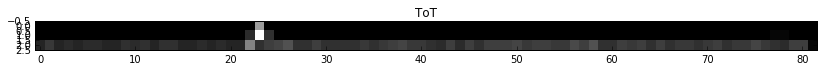

In [3]:
def event_id_cluster_bit_length(cluster_tot, event_id):
    return event_id

def zrle_event_bit_length(event):
    return zrle_cluster_bit_length(event, -1) - 19 - bit_size_ex_golumb(event.shape[0] - 2)

def zrle_cluster_bit_length(cluster_tot, event_id):
    bit_sum = 0
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot))]):
            bits = 2*7 if val == 0 else count*7
            bit_sum += bits
    return bit_sum + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def bit_size_ex_golumb(val):
    x = -val*2 + 1 if val <= 0 else val*2
    bits = int(floor(log(x)/log(2)))
    return bits + bits + 1

def line_cluster_bit_length(cluster_tot, event_id):
    left_max = np.argmax(cluster_tot, axis=0)[0]
    right_max = np.argmax(cluster_tot, axis=0)[-1]
    y0 = left_max
    y1 = right_max
    num = cluster_tot.shape[1]
    x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
    mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
    prediction = np.round(make_line_prediction(cluster_tot.shape, y0, y1) * mean)
    
    # Left and right edge and mean
    bit_sum = 7*3
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot - prediction))]):
            val_ex_golumnb = bit_size_ex_golumb(val)
            bits = val_ex_golumnb + bit_size_ex_golumb(count) if val == 0 else count*val_ex_golumnb
            #print count, val, '->', bits
            bit_sum += bits
    return bit_sum + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def line_lzw_cluster_bit_length(cluster_tot, event_id):
    left_max = np.argmax(cluster_tot, axis=0)[0]
    right_max = np.argmax(cluster_tot, axis=0)[-1]
    y0 = left_max
    y1 = right_max
    num = cluster_tot.shape[1]
    x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
    mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
    prediction = np.round(make_line_prediction(cluster_tot.shape, y0, y1) * mean)
    
    bit_range = int(np.max(cluster_tot - prediction) - np.min(cluster_tot - prediction) + 1)
    seq = (cluster_tot - prediction - np.min(cluster_tot - prediction)).ravel().astype(int)
    seq_compressed = lzw(seq, bit_range)
    bits_per_code = int(ceil(log(0.1+np.max(seq_compressed + [1]))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 8 + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def lzw(seq, dictionary_size):
    dictionary = dict(((i,), i) for i in xrange(0, dictionary_size))
    size = len(dictionary)

    buf = []
    out = []
    
    for i in seq:
        sym = [i]
        if tuple(buf+sym) in dictionary:
            buf = buf+sym
        else:
            out.append(dictionary[tuple(buf)])
            dictionary[tuple(buf+sym)] = size
            size += 1
            buf = sym
    if buf:
        out.append(dictionary[tuple(buf)])
    return out

def lzw_decompress(compressed_seq, dictionary_size):
    dictionary = dict((i, [i]) for i in xrange(0, dictionary_size))
    size = len(dictionary)
    
    out = []
    buf = dictionary[compressed_seq.pop(0)]
    out += buf
    for i in compressed_seq:
        if i in dictionary:
            entry = dictionary[i]
        elif i == size:
            entry = buf + [buf[0]]
        else:
            raise ValueError('Bad compressed i: %s' % i)
        out += entry

        dictionary[size] = buf + [entry[0]]
        size += 1
 
        buf = entry
    return out

def lzw2(sequence, dictionary_size):
    codes = dict([(chr(x), x) for x in range(dictionary_size)])
    
    compressed_data = []
    code_count = dictionary_size
    current_string = ""
    for i in sequence:
        c = chr(i)
        current_string = current_string + c
        if not (codes.has_key(current_string)):
            codes[current_string] = code_count
            compressed_data.append(codes[current_string[:-1]])
            code_count += 1
            current_string = c
    compressed_data.append(codes[current_string])
    return compressed_data

def lzw2_decompress(compressed_data, dictionary_size):
    strings = dict([(x, [x]) for x in range(dictionary_size)])
    
    next_code = dictionary_size
    decompressed_sequence = []
    previous_string = []
    for c in compressed_data:
        if not (strings.has_key(c)):
            strings[c] = previous_string + [previous_string[0]]
        decompressed_sequence += strings[c]
        if not(len(previous_string) == 0):
            strings[next_code] = previous_string + [strings[c][0]]
            next_code +=1
        previous_string = strings[c]
    return decompressed_sequence

def lzw_event_bit_length(event):
    return lzw2_cluster_bit_length(event, -1) - 19 - bit_size_ex_golumb(event.shape[0] - 2)

def lzw2_cluster_bit_length(cluster_tot, event_id):
    bit_range = int(np.max(cluster_tot) + 1)
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw2(seq, bit_range)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def lzw_cluster_bit_length(cluster_tot, event_id):
    bit_range = int(np.max(cluster_tot) + 1)
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw(seq, bit_range)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def lzw_cds_cluster_bit_length(cluster_tot, event_id):
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw(seq, 128)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    return len(seq_compressed)*bits_per_code + 8 + 19 + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

def row_cluster_event_bit_length(event):
    return row_cluster_cluster_bit_length(event, -1)

def row_cluster_cluster_bit_length(cluster_tot, event_id):
    bit_sum = 0
    binary_cluster = np.zeros(cluster_tot.shape)
    binary_cluster[np.where(cluster_tot > 0)] = 1
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(binary_cluster))]):
            bits = 0 if val == 0 else count*7 + 19
            bit_sum += bits
    return bit_sum

def base_event_bit_length(event):
    return base_cluster_bit_length(event, -1)

def base_cluster_bit_length(cluster_tot, event_id):
    num_hits = len(np.where(cluster_tot > 0)[0])
    return num_hits * (19 + 7)

def cluster_event_bit_length(event):
    return cluster_cluster_bit_length(event, -1) - 19 - bit_size_ex_golumb(event.shape[0] - 2)

def cluster_cluster_bit_length(cluster_tot, event_id):
    length = cluster_tot.shape[1]
    height = cluster_tot.shape[0]
    return 19 + 7*length*height + bit_size_ex_golumb(cluster_tot.shape[0] - 2)

cluster_tots = get_cluster_tots(25, 10)
cluster_tot = cluster_tots[1][1]
show_gray(cluster_tot, 'ToT', vmin=0)

print lzw_cluster_bit_length(cluster_tot, 1)
print lzw2_cluster_bit_length(cluster_tot, 1)
print lzw_cds_cluster_bit_length(cluster_tot, 1)
print line_cluster_bit_length(cluster_tot, 1)
print line_lzw_cluster_bit_length(cluster_tot, 1)
print zrle_cluster_bit_length(cluster_tot, 1)
print row_cluster_cluster_bit_length(cluster_tot, 1)
print base_cluster_bit_length(cluster_tot, 1)
print event_id_cluster_bit_length(cluster_tot, 1)

algs = ['base', 'row_cluster', 'zrle', 'lzw']

hits = get_hits(25, 10)
image = get_tot_image(hits, 1)
#show_gray(image, 'Single event ToT', origin='lower')

for alg in algs:
    timing_start()
    print alg, globals()[alg + '_event_bit_length'](image), timing_end()

In [4]:
def bit_sizes_for_alg_path_and_filename(eta, phi, alg):
    return ('data/compression_bit_sizes/' + str(eta) + '/' + str(phi) + '/', alg + '.npy')

def load_bit_sizes_for_alg(eta, phi, alg):
    path, filename = bit_sizes_for_alg_path_and_filename(eta, phi, alg)
    if not os.path.exists(path):
        os.makedirs(path)
        
    bits = [[] for x in range(1000)]
    
    cluster_tots = get_cluster_tots(eta, phi)
    for eventID, clusters in cluster_tots.iteritems():
        for (i, cluster_tot) in enumerate(clusters):
            length = min(len(np.where(cluster_tot > 0)[0]), 999)
            cluster_bit_length = globals()[alg + '_cluster_bit_length'](cluster_tot, eventID)
            bits[length].append(cluster_bit_length)
    
    np.save(path + filename, bits)
    return bits
        
def get_bit_sizes_for_alg(eta, phi, alg, force_reload=False):
    path, filename = bit_sizes_for_alg_path_and_filename(eta, phi, alg)
    if force_reload or not os.path.exists(path + filename):
        return load_bit_sizes_for_alg(eta, phi, alg)
    else:
        return np.load(path + filename)

In [16]:
algs = ['cluster', 'row_cluster', 'zrle', 'line', 'lzw']

for eta_i in range(-31, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            get_bit_sizes_for_alg(eta_i, phi_i, alg, force_reload=False)
    print

eta: -31 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi

eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -11 phi

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in divide


 0.376503427964


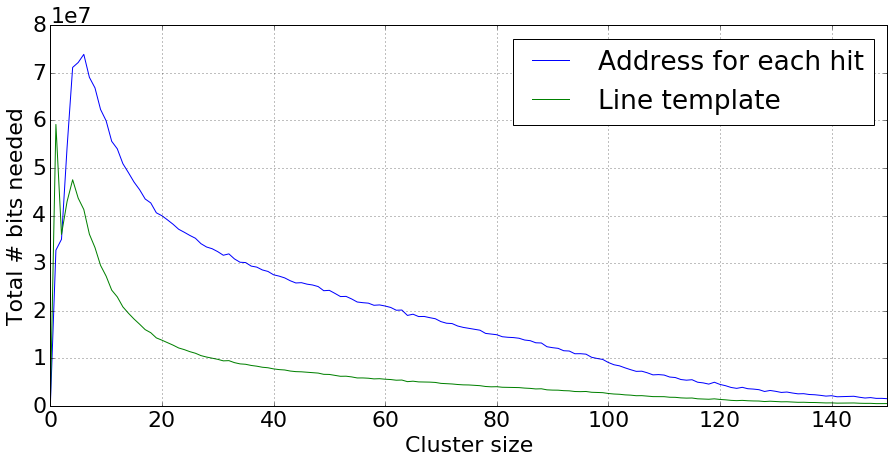

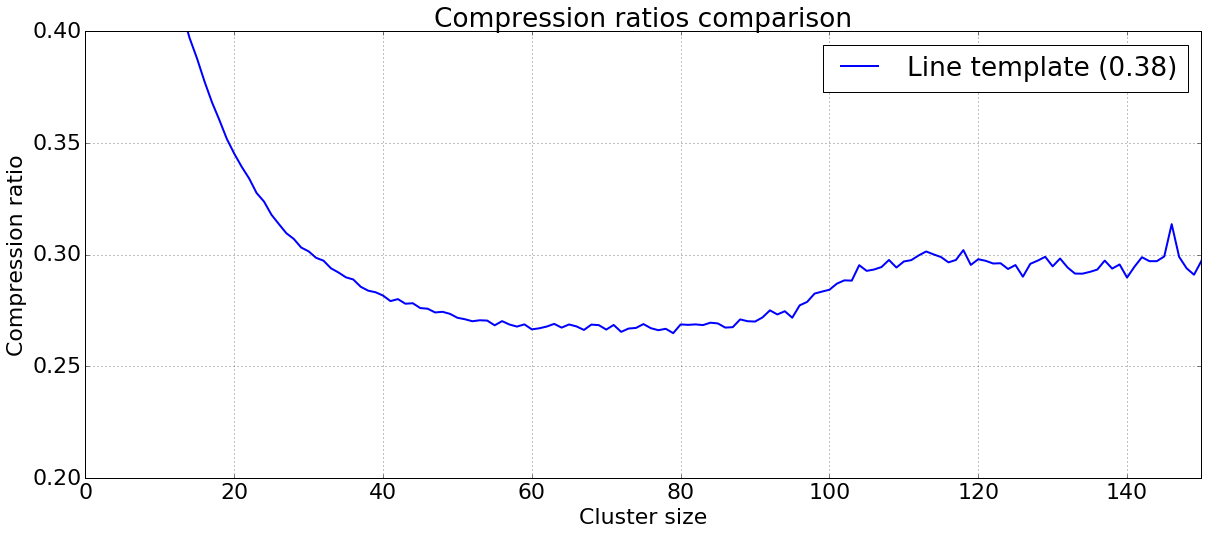

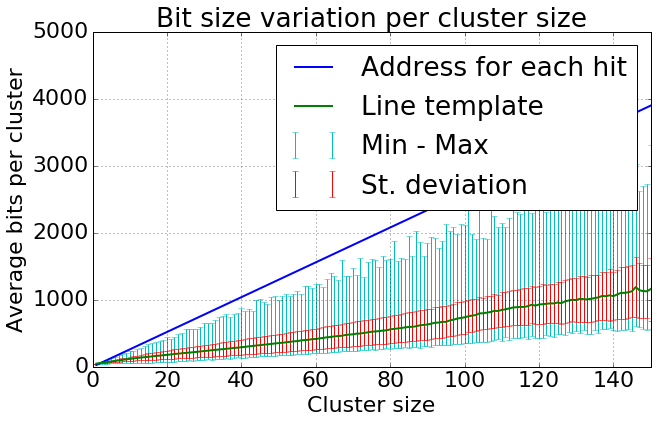

In [36]:
#algs = ['base', 'cluster', 'row_cluster', 'zrle', 'line', 'lzw', 'lzw_cds', 'line_lzw']
algs = ['base', 'line']

compression_bits = {}
for alg in algs:
    compression_bits[alg] = [[] for x in range(1000)]

for eta_i in range(-30, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bits_per_size = get_bit_sizes_for_alg(eta_i, phi_i, alg)
            for size, bits in enumerate(bits_per_size):
                if len(bits) > 0:
                    compression_bits[alg][size] += bits
    print

plt.figure(figsize=(15,15))
plt.subplot(211)

alg_labels = {
    'base': 'Address for each hit', 
    'zrle': 'ZRLE',
    'line': 'Line template',
    'lzw':  'LZW'
    #'cluster': 'Address for each cluster + list pixels within cluster (include zeros)',
    #'row_cluster': 'Address for each cluster + list pixels within cluster (clusters only in z-direction)',
    #'zrle': 'Address for each cluster + list pixels within cluster (ZRLE)',
    #'line': 'Address for each cluster + list pixels within cluster (ZRLE + Line prediction)',
    #'line_lzw': 'Address for each cluster + list pixels within cluster (LZW + Line prediction)',
    #'lzw': 'Address for each cluster + list pixels within cluster (LZW)',
    #'lzw_cds': 'Address for each cluster + list pixels within cluster (LZW with constant dictionary size)',
    #'optimal': 'The best option'
}

base_sums = np.zeros((1000))+0.00001
for i, bits in enumerate(compression_bits['base']):
    base_sums[i] = np.sum(bits)
base_total_sum = np.sum(base_sums)

overall_ratios = {}
for alg in algs:
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot( sums, label=alg_labels[alg])
    overall_ratios[alg] = np.sum(sums) / base_total_sum
    print 'Overall compression ratio(' + alg +  '):', overall_ratios[alg]
    
plt.legend()
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Total # bits needed')
plt.xlim([0, 150])

plt.figure(figsize=(20,8))
#plt.subplot(212)
for alg in algs:
    if alg == 'base':
        continue
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, linewidth=2, label=alg_labels[alg] + ' ('+ str(round(overall_ratios[alg]*100)/100) + ')')
plt.legend()
plt.xlim([0, 150])
plt.ylim([0.2, 0.4])
plt.xlabel('Cluster size')
plt.grid(True)
plt.title('Compression ratios comparison')
plt.ylabel('Compression ratio')
plt.savefig('compression_ratios_comp2.png')

plt.figure(figsize=(10, 6))

for i, alg in enumerate(algs):
    if alg == 'base':
        continue
    plt.subplot(1,1,i)
    err = np.zeros((1000))
    avg = np.zeros((1000))
    max_bits = np.zeros((1000))
    min_bits = np.zeros((1000))
    sums = np.zeros((1000))
    counts = np.zeros((1000)) + 0.0001
    for i, bits in enumerate(compression_bits[alg]):
        err[i] = np.std(bits)
        max_bits[i] = np.max(bits + [0])
        min_bits[i] = np.min(bits + [99999999])
        sums[i] = np.sum(bits)
        counts[i] = len(bits)
        avg[i] = np.mean(bits)
    err_up = max_bits - avg
    err_down = avg - min_bits
    plt.errorbar(range(1000), avg, yerr=[err_down, err_up], label='Min - Max', color='none', ecolor='c')
    plt.errorbar(range(1000), avg, yerr=err, label='St. deviation', color='none', ecolor='r')
    plt.plot(1.0*base_sums/counts, linewidth=2, label=alg_labels['base'])
    plt.plot(avg, linewidth=2, label=alg_labels[alg])
    plt.legend()
    plt.xlim([0, 150])
    plt.ylim([0, 5000])
    #plt.yscale('log')
    plt.xlabel('Cluster size')
    plt.grid(True)
    plt.title('Bit size variation per cluster size')
    plt.ylabel('Average bits per cluster')
plt.savefig('compression_ratios_comp3.png')

# TODO: cluster shape information

Overall compression ratio(base): 1.0
Overall compression ratio(cluster): 0.655855068743
Overall compression ratio(row_cluster): 0.385092610417
Overall compression ratio(zrle): 0.394783611703
Overall compression ratio(line): 0.376503427964
Overall compression ratio(lzw): 0.338829341283
Overall compression ratio(lzw_cds): 0.38393511182
Overall compression ratio(line_lzw):

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide


 0.370174940037
Overall compression ratio(optimal): 0.316385110925


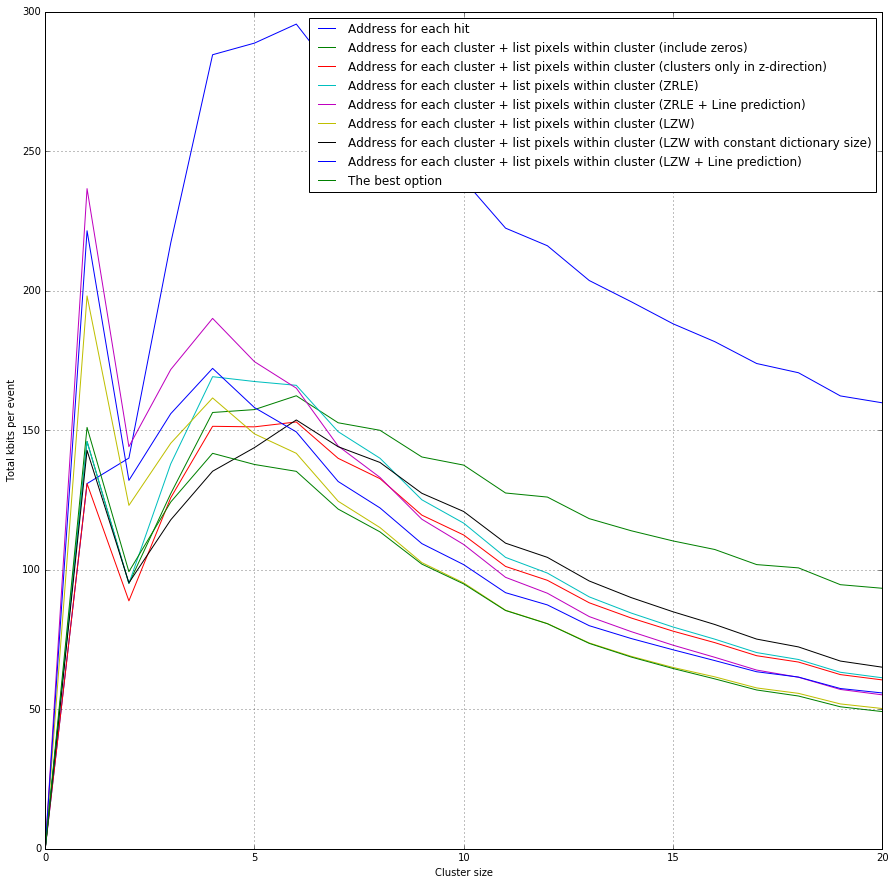

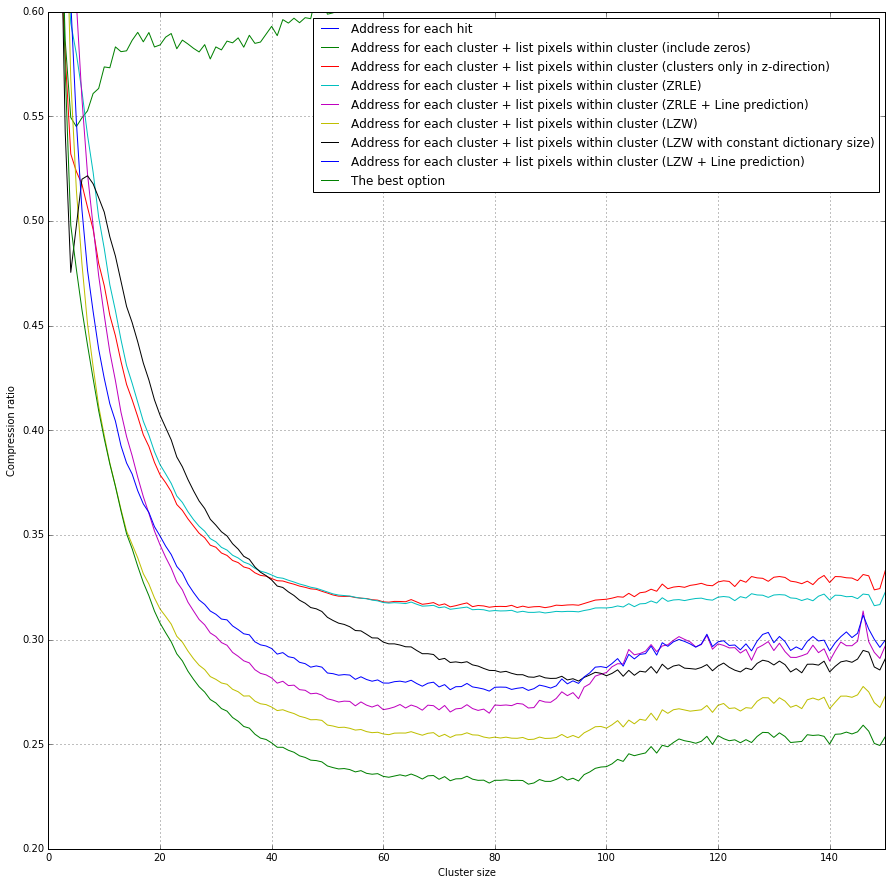

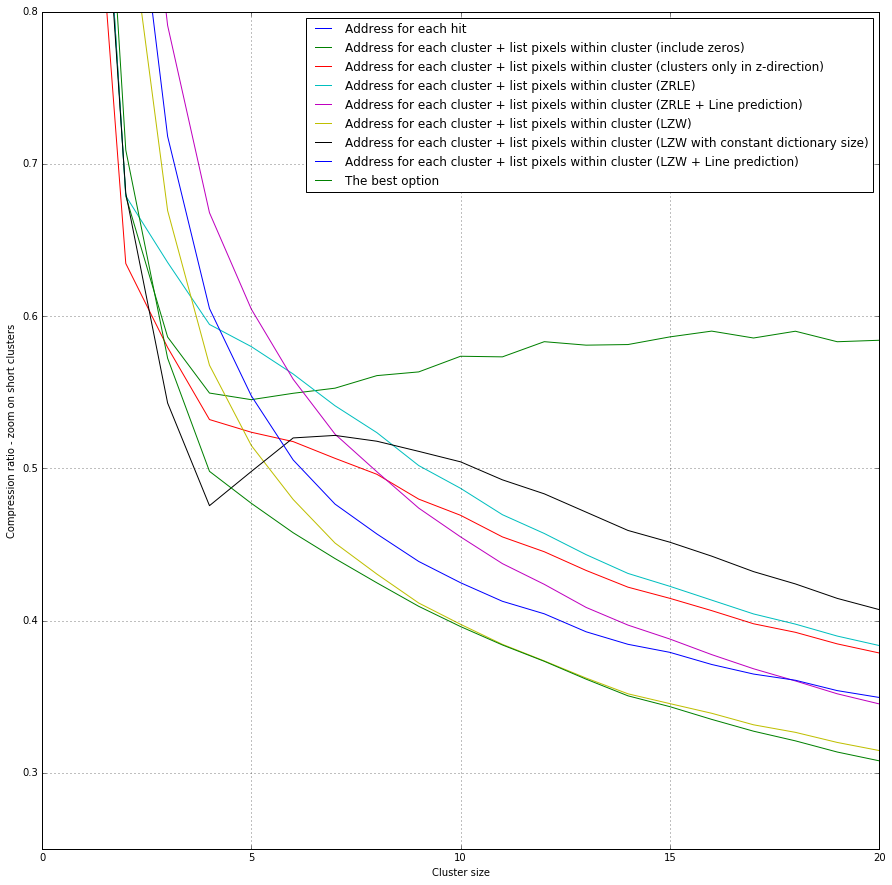

In [22]:
base_sums = np.zeros((1000))+0.00001
for i, bits in enumerate(compression_bits['base']):
    base_sums[i] = np.sum(bits)
base_total_sum = np.sum(base_sums)

compression_bits['optimal'] = [None] * 1000
for i in range(0, 1000):
    bits_for_length = np.array(compression_bits['base'][i])
    for alg in algs:
        bits_for_length = np.c_[bits_for_length, compression_bits[alg][i]]
    compression_bits['optimal'][i] = np.min(bits_for_length, axis=1) + 4

plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot( sums/250000, label=alg_labels[alg])
    print 'Overall compression ratio(' + alg +  '):', np.sum(sums) / base_total_sum

plt.legend()
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Total kbits per event')
plt.xlim([0, 20])
    
plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, label=alg_labels[alg])
plt.legend()
plt.xlim([0, 150])
plt.ylim([0.2, 0.6])
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Compression ratio')
plt.savefig('compression_optimal_all.png')

plt.figure(figsize=(15,15))
for alg in (algs + ['optimal']):
    sums = np.zeros((1000))
    for i, bits in enumerate(compression_bits[alg]):
        sums[i] = np.sum(bits)
    plt.plot(1.0*sums/base_sums, label=alg_labels[alg])
plt.legend()
plt.xlim([0, 20])
plt.ylim([0.25, 0.8])
plt.xlabel('Cluster size')
plt.grid(True)
plt.ylabel('Compression ratio - zoom on short clusters')
plt.savefig('compression_optimal_short.png')

In [27]:
#algs = ['base', 'cluster', 'row_cluster', 'zrle', 'line', 'lzw', 'lzw_cds', 'line_lzw']
algs = ['base', 'lzw']
compression_variation = {}
for alg in algs:
    compression_variation[alg] = []

for eta_i in range(-30, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bits_per_size = get_bit_sizes_for_alg(eta_i, phi_i, alg)
            event_ids_per_size = get_bit_sizes_for_alg(eta_i, phi_i, 'event_id')
            total_bits_for_event = {}
            for size, bits in enumerate(bits_per_size):
                if len(bits) > 0:
                    event_ids = event_ids_per_size[size]
                    for i, bit_size in enumerate(bits):
                        eventId = event_ids[i]
                        if eventId in total_bits_for_event:
                            total_bits_for_event[eventId] += bit_size
                        else:
                            total_bits_for_event[eventId] = bit_size
            for eventId, bit_size in total_bits_for_event.iteritems(): 
                compression_variation[alg] += [(abs(eta_i)-1, bit_size)]
            #print alg, np.sum(total_bits_for_module)
    print

eta: -30 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -29 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -28 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -27 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -26 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -25 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -24 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -23 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -22 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -21 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: -11 phi

12.7744647333 5.48161637207
4.32836347083 1.72349539607


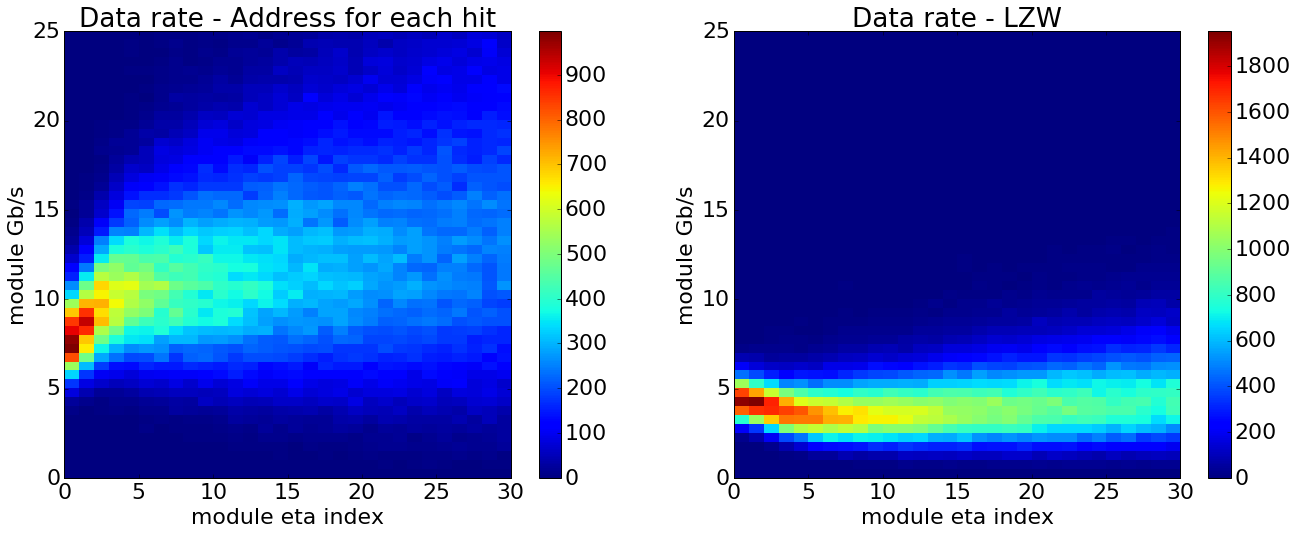

In [32]:
plt.figure(figsize=(22, 8))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

for i, alg in enumerate(algs):
    plt.subplot(1, 2, i + 1)
    bits_sizes = np.array(compression_variation[alg])[:, 1]/1000.0
    etas = np.array(compression_variation[alg])[:, 0]
    print np.mean(bits_sizes), np.std(bits_sizes)
    H, yedges, xedges = np.histogram2d(bits_sizes, etas, bins=(np.linspace(0, 25, 51), range(0, 31)))
    plt.imshow(H, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')
    plt.ylabel('module Gb/s')
    plt.xlabel('module eta index')
    #plt.title(alg_labels[alg])
    plt.title('Data rate - ' + alg_labels[alg])
plt.savefig('total_bits_per_eta.png')

236
base 6604
row_cluster 2975
zrle 2674
lzw 9626


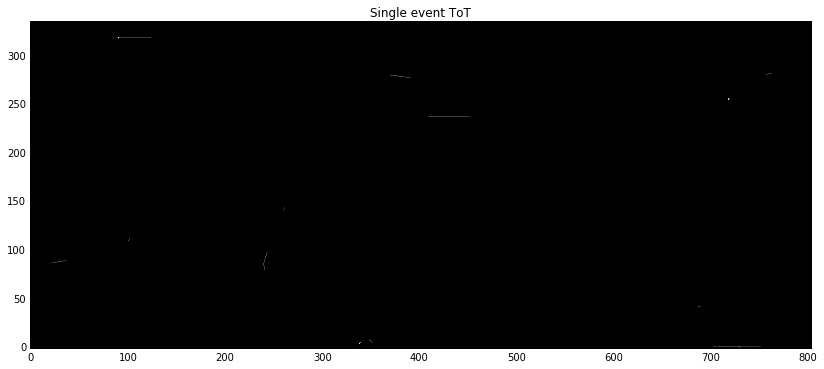

In [96]:
algs = ['base', 'row_cluster', 'zrle', 'lzw']

hits = get_hits(15, 7)
image = get_tot_image(hits, 1)
show_gray(image, 'Single event ToT', origin='lower')

events = list(np.unique(hits[2,:hits.shape[1]/4]))

for alg in algs:
    print alg, globals()[alg + '_event_bit_length'](image)

In [99]:
algs = ['base', 'row_cluster', 'zrle', 'lzw']

event_bit_sizes = {}
for alg in algs:
    event_bit_sizes[alg] = []

for eta_i in range(-30, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(10,11):
        print phi_i,
        hits = get_hits(eta_i, phi_i)
        events = list(np.unique(hits[2,:hits.shape[1]/4]))
        for eventID in events:
            event = get_hit_image(hits, eventID)
            for alg in algs:
                event_bit_length = globals()[alg + '_event_bit_length'](event)
                event_bit_sizes[alg] += [(event_bit_length, eta_i, phi_i, eventId)]
    print

eta: -30 phi: 10
eta: -29 phi: 10
eta: -28 phi: 10
eta: -27 phi: 10
eta: -26 phi: 10
eta: -25 phi: 10
eta: -24 phi: 10
eta: -23 phi: 10
eta: -22 phi: 10
eta: -21 phi: 10
eta: -20 phi: 10
eta: -19 phi: 10
eta: -18 phi: 10
eta: -17 phi: 10
eta: -16 phi: 10
eta: -15 phi: 10
eta: -14 phi: 10
eta: -13 phi: 10
eta: -12 phi: 10
eta: -11 phi: 10
eta: -10 phi: 10
eta: -9 phi: 10
eta: -8 phi: 10
eta: -7 phi: 10
eta: -6 phi: 10
eta: -5 phi: 10
eta: -4 phi: 10
eta: -3 phi: 10
eta: -2 phi: 10
eta: -1 phi: 10
eta: 0 phi: 10
eta: 1 phi: 10
eta: 2 phi: 10
eta: 3 phi: 10
eta: 4 phi: 10
eta: 5 phi: 10
eta: 6 phi: 10
eta: 7 phi: 10
eta: 8 phi: 10
eta: 9 phi: 10
eta: 10 phi: 10
eta: 11 phi: 10
eta: 12 phi: 10
eta: 13 phi: 10
eta: 14 phi: 10
eta: 15 phi: 10
eta: 16 phi: 10
eta: 17 phi: 10
eta: 18 phi: 10
eta: 19 phi: 10
eta: 20 phi: 10
eta: 21 phi: 10
eta: 22 phi: 10
eta: 23 phi: 10
eta: 24 phi: 10
eta: 25 phi: 10
eta: 26 phi: 10
eta: 27 phi: 10
eta: 28 phi: 10
eta: 29 phi: 10
eta: 30 phi: 10


In [113]:
event_bit_sizes_final = {}
for alg in algs:
    l = len(event_bit_sizes[alg])
    event_bit_sizes_final[alg] = np.hstack([np.array(event_bit_sizes[alg]).reshape((l, 1)), np.array(event_bit_sizes2[alg])])

In [114]:
outfile = open('data/event_bit_sizes_final.dat', 'wb')
cPickle.dump(event_bit_sizes_final, outfile, protocol=pickle.HIGHEST_PROTOCOL)
outfile.close()

12.5995676844 5.38946702859
4.74709537963 2.02492448682
4.31261821129 1.88161519559
8.53823291002 0.752163419101


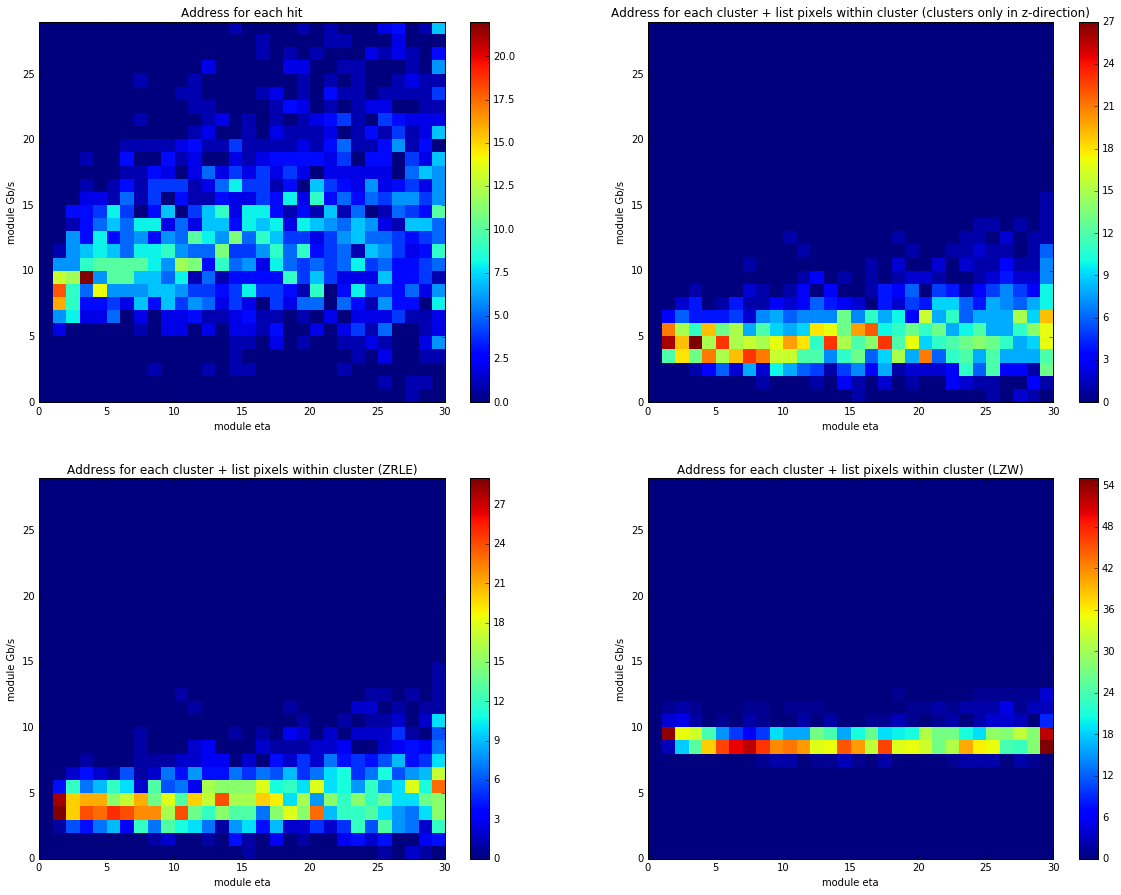

In [118]:
plt.figure(figsize=(20, 15))

for i, alg in enumerate(algs):
    plt.subplot(2, 2, i + 1)
    bits_sizes = np.array(event_bit_sizes_final[alg])[:, 0]/1000
    etas = np.array(event_bit_sizes_final[alg])[:, 1]
    print np.mean(bits_sizes), np.std(bits_sizes)
    H, yedges, xedges = np.histogram2d(bits_sizes, etas, bins=(range(0, 30, 1), range(0, 31)))
    plt.imshow(H, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')
    plt.ylabel('module Gb/s')
    plt.xlabel('module eta')
    plt.title(alg_labels[alg])
plt.savefig('total_bits_per_eta.png')

8


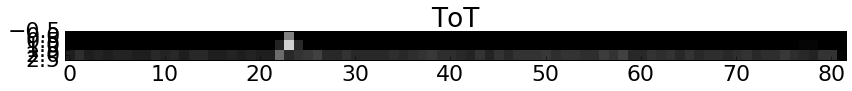

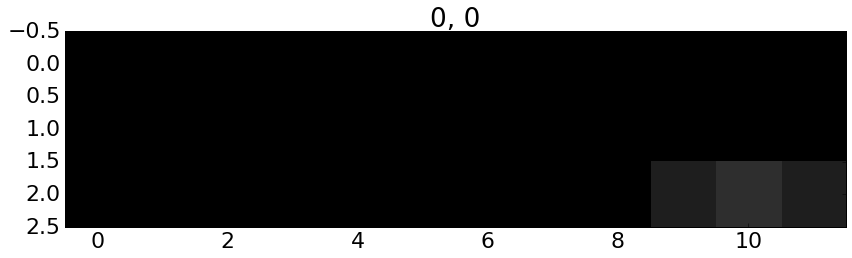

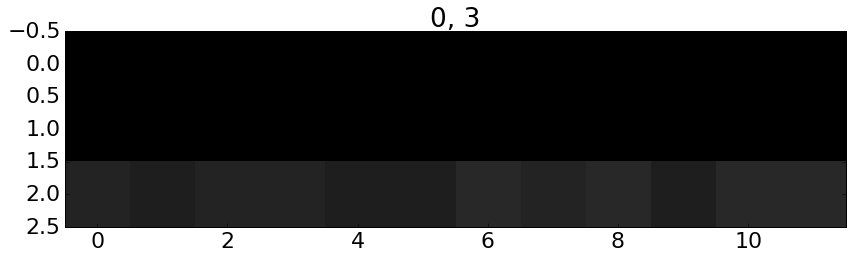

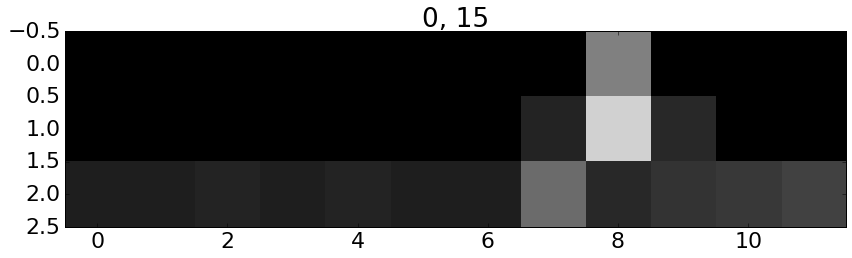

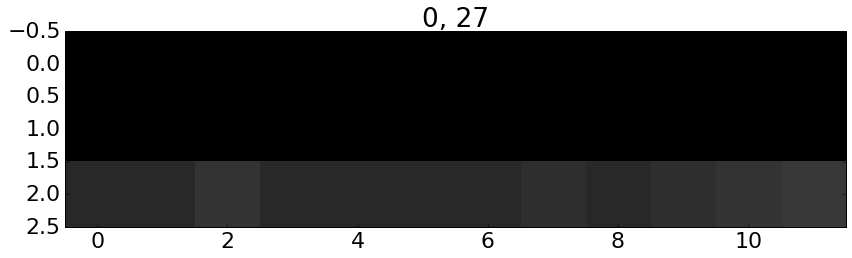

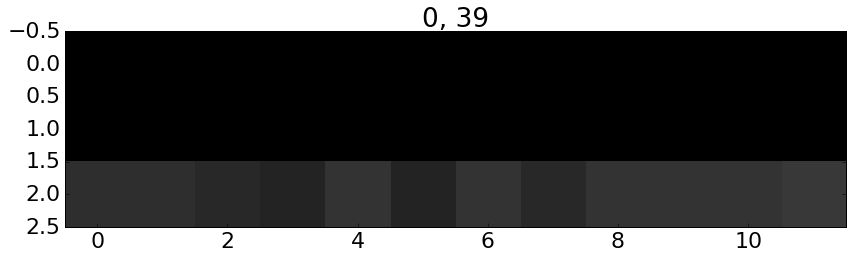

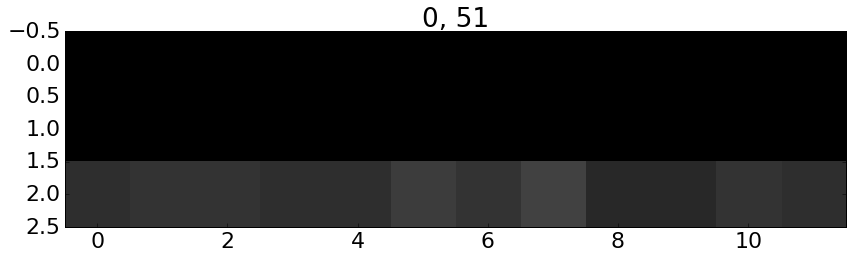

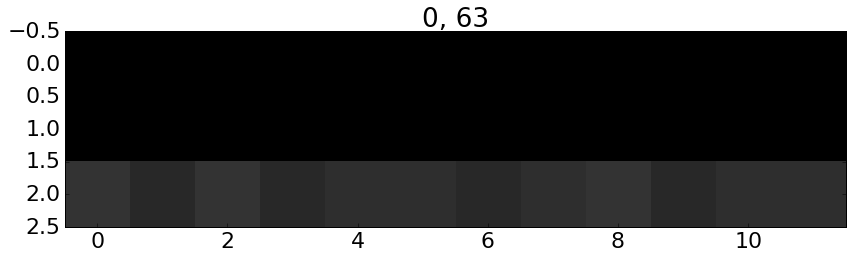

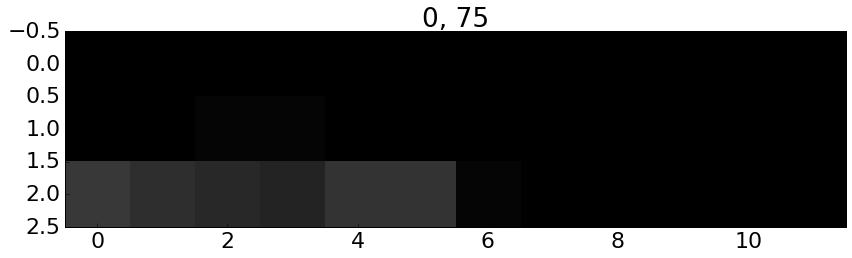

In [37]:
def regions_from_cluster(cluster_tot, cluster_pos, NX = 1, NY = 4):
    x1, y1, x2, y2 = cluster_pos
    nx1 = int(floor(x1 * 1.0 / NX) * NX)
    nx2 = int(ceil((x2 + 1) * 1.0 / NX) * NX)
    ny1 = int(floor(y1 * 1.0 / NY) * NY)
    ny2 = int(ceil((y2 + 1) * 1.0 / NY) * NY)
    
    regions = []
    for i in range(nx1, nx2, NX):
        for j in range(ny1, ny2, NY):
            rx1, ry1, rx2, ry2 = i - x1, j - y1, i - x1 + NX, j - y1 + NY
            arx1, ary1, arx2, ary2 = max(0, rx1), max(0, ry1), min(rx2, cluster_tot.shape[0]), min(ry2, cluster_tot.shape[1])
            #print rx1, ry1, rx2, ry2
            region = cluster_tot[arx1:arx2, ary1:ary2]
            if region.sum() > 0:
                while ry1 < 0:
                    region = np.c_[ np.zeros(region.shape[0]), region ]
                    ry1 += 1
                while ry2 > ary2:
                    region = np.c_[ region, np.zeros(region.shape[0]) ]
                    ry2 -= 1
                while rx1 < 0:
                    region = np.r_[ [np.zeros(region.shape[1])], region ]
                    rx1 += 1
                while rx2 > arx2:
                    region = np.r_[ region, [np.zeros(region.shape[1])] ]
                    rx2 -= 1
                regions += [(region, rx1, ry1)]
    return regions

cluster_tots = get_cluster_tots(25, 10)
poses = cluster_positions(25, 10)
cluster_tot = cluster_tots[1][1]
cluster_pos = poses[1][1]
show_gray(cluster_tot, 'ToT', vmin=0, vmax=50)
regions = regions_from_cluster(cluster_tot, cluster_pos, 3, 12)
print len(regions)
for (region, x, y) in regions:
    show_gray(region, str(x) + ', ' + str(y), vmin=0, vmax=50)

In [38]:
## Helper functions related to retrieving regions

def regions_path_and_filename(eta, phi, NX, NY):
    return ('data/regions/'+ str(NX) + 'x' + str(NY) + '/' + str(eta) + '/', str(phi) + '.dat')

def load_regions(eta, phi, NX, NY):
    path, filename = regions_path_and_filename(eta, phi, NX, NY)
    
    cluster_tots = get_cluster_tots(eta, phi)
    poses = cluster_positions(eta, phi)
    
    regions = {}
    hits = get_hits(eta, phi)
    for eventID, positions in poses.iteritems():
        regions_arr = []
        for i, cluster_pos in enumerate(positions):
            cluster_tot = cluster_tots[eventID][i]
            regions_arr.append(regions_from_cluster(cluster_tot, cluster_pos, NX, NY))
        regions[eventID] = regions_arr 
        
    if not os.path.exists(path):
        os.makedirs(path)
    outfile = open(path + filename, 'wb')
    cPickle.dump(regions, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    outfile.close()
    return regions

def get_regions(eta, phi, NX=1, NY=4):
    path, filename = regions_path_and_filename(eta, phi, NX, NY)
    if not os.path.exists(path + filename):
        return load_regions(eta, phi, NX, NY)
    else:
        infile = open(path + filename, 'r')
        data = cPickle.load(infile)
        infile.close
        return data

In [204]:
for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:', 
    for phi_i in range(0, 16):
        print phi_i,
        regions = get_regions(eta_i, phi_i, 4, 16)
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

40 optimal
0.671148300171
45 lzw
0.0479221343994
37 lzw_cds
0.182151794434
49 lzw_cds2
0.0598430633545
37 line
0.17786026001
45 zrle
0.028133392334
38 bitmask
0.0400543212891
38 bitmask2
0.0519752502441
108 single_hit
0.0138282775879
45 region
0.0159740447998
104 base
0.014066696167
-1 event_id
0.0131130218506


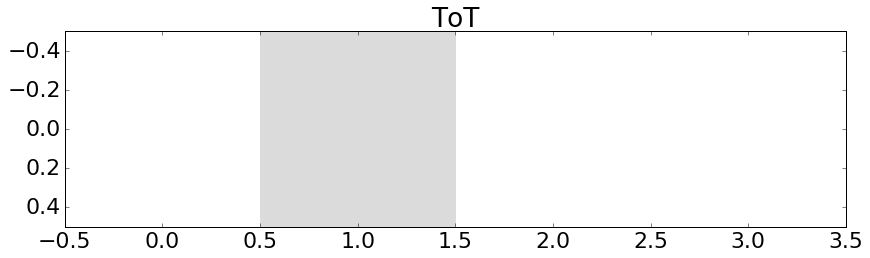

In [39]:
def event_id_region_bit_length(region, event_id):
    return event_id

def region_address_size(region):
    return int(ceil(log(272160/region.shape[0]/region.shape[1])/log(2)))

def zrle_region_bit_length(cluster_tot, event_id):
    bit_sum = 0
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot))]):
            bits = 2*7 if val == 0 else count*7
            bit_sum += bits
    
    return bit_sum + region_address_size(cluster_tot)

def line_region_bit_length(cluster_tot, event_id):
    maxes = np.argmax(cluster_tot, axis=0)
    y0 = maxes[0]
    y1 = maxes[-1]
    num = cluster_tot.shape[1]
    x, y = np.linspace(0, cluster_tot.shape[1]-1, num), np.linspace(y0, y1, num)
    mean = cluster_tot[np.round([y,x]).astype(int).tolist()].mean()
    prediction = np.round(make_line_prediction(cluster_tot.shape, y0, y1) * mean)
    
    # Left and right edge and mean
    bit_sum = int(ceil(log(region.shape[0])/log(2)))*2 + 7
    for i, (count, val) in enumerate([(len(list(group)), value) for value, group in groupby(np.ravel(cluster_tot - prediction))]):
            val_ex_golumnb = bit_size_ex_golumb(val)
            bits = val_ex_golumnb + bit_size_ex_golumb(count) if val == 0 else count*val_ex_golumnb
            bit_sum += bits
    return bit_sum + region_address_size(cluster_tot)

def lzw_region_bit_length(cluster_tot, event_id):
    bit_range = int(np.max(cluster_tot) + 1)
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw2(seq, bit_range)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    # Encoded sequence + encoding size + dictionary size + address
    return len(seq_compressed)*bits_per_code + 8 + 8 + region_address_size(cluster_tot)

def lzw_cds_region_bit_length(cluster_tot, event_id):
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw2(seq, 128)
    bits_per_code = int(ceil(log(np.max(seq_compressed))/log(2)))
    # Encoded sequence + encoding size + address (dictionary size are constant)
    return len(seq_compressed)*bits_per_code + 8 + region_address_size(cluster_tot)

def lzw_cds2_region_bit_length(cluster_tot, event_id):
    seq = cluster_tot.ravel().astype(int)
    seq_compressed = lzw2(seq, 128)
    bits_per_code = 8
    # Encoded sequence + address (encoding size + dictionary size are constant)
    return len(seq_compressed)*bits_per_code + region_address_size(cluster_tot)

def base_region_bit_length(cluster_tot, event_id):
    num_hits = np.count_nonzero(cluster_tot)
    return num_hits * (19 + 7)

def single_hit_region_bit_length(cluster_tot, event_id):
    num_hits = np.count_nonzero(cluster_tot)
    # addresses + tots + number of hits in unary
    return num_hits * (19 + 7) + num_hits

def region_region_bit_length(cluster_tot, event_id):
    length = cluster_tot.shape[1]
    height = cluster_tot.shape[0]
    return region_address_size(cluster_tot) + 7*length*height

def bitmask2_region_bit_length(cluster_tot, event_id):
    length = cluster_tot.shape[1]
    height = cluster_tot.shape[0]
    hits = cluster_tot[cluster_tot.nonzero()]
    mean = int(np.mean(hits))
    pixel_bit_size = 0
    for pixel_value in hits:
        pixel_bit_size += bit_size_ex_golumb(pixel_value - mean)
    # Bitmask + mean + ex. golomb + address
    return length*height + 7 + pixel_bit_size + region_address_size(cluster_tot)

def bitmask_region_bit_length(cluster_tot, event_id):
    length = cluster_tot.shape[1]
    height = cluster_tot.shape[0]
    
    mean = int(cluster_tot.sum()/len(cluster_tot.nonzero()[0]))
    pixel_bit_size = 0
    for pixel_value in cluster_tot.ravel():
        if pixel_value > 0:
            pixel_bit_size += bit_size_ex_golumb(pixel_value - mean)
    # Bitmask + mean + ex. golomb + address
    return length*height + 7 + pixel_bit_size + region_address_size(cluster_tot)

def optimal_region_bit_length(cluster_tot, event_id):
    min_bits = single_hit_region_bit_length(cluster_tot, event_id)
    algs = ['lzw', 'line', 'bitmask']
    for alg in algs:
        bit_size = globals()[alg + '_region_bit_length'](cluster_tot, event_id)
        if bit_size < min_bits:
            min_bits = bit_size
    # 2 bits to choose out from 4 algs
    return min_bits + 3

regions = get_regions(25, 10, 1, 4)
region, x, y = np.array(regions[1][1][5])

show_gray(region, 'ToT', vmin=0)

algs = ['optimal', 'lzw', 'lzw_cds', 'lzw_cds2', 'line', 'zrle', 'bitmask', 'bitmask2', 'single_hit', 'region', 'base', 'event_id']

for alg in algs:
    timing_start()
    print globals()[alg + '_region_bit_length'](region, -1), alg
    print timing_end()

In [40]:
def region_bit_sizes_for_alg_path_and_filename(eta, phi, alg, x, y):
    region_size = str(x) + 'x' + str(y)
    return ('data/compression_bit_sizes/regions/' + region_size + '/' + str(eta) + '/' + str(phi) + '/', alg + '.npy')

def load_region_bit_sizes_for_alg(eta, phi, alg, x, y):
    path, filename = region_bit_sizes_for_alg_path_and_filename(eta, phi, alg, x, y)
    if not os.path.exists(path):
        os.makedirs(path)
    
    bits = []
    regions = get_regions(eta_i, phi_i, x, y)
    for eventID, regions_for_event in regions.iteritems():
        for region, x, y in list(chain.from_iterable(regions_for_event)):
            region_bit_length = globals()[alg + '_region_bit_length'](region, eventID)
            bits.append(region_bit_length)
    
    np.save(path + filename, bits)
    return bits
        
def get_region_bit_sizes_for_alg(eta, phi, alg, x, y, force_reload=False):
    path, filename = region_bit_sizes_for_alg_path_and_filename(eta, phi, alg, x, y)
    if force_reload or not os.path.exists(path + filename):
        return load_region_bit_sizes_for_alg(eta, phi, alg, x, y)
    else:
        return np.load(path + filename)

In [111]:
algs = ['base', 'region', 'lzw', 'zrle', 'bitmask', 'single_hit', 'line' ,'event_id']

for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i, 
        for alg in algs:
            get_region_bit_sizes_for_alg(eta_i, phi_i, alg, 4, 16)
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

In [81]:
algs = ['base', 'region', 'lzw', 'zrle', 'bitmask', 'single_hit', 'line' ,'event_id']
timings = {}
for alg in algs:
    timings[alg] = 0

for eta_i in range(15, 16):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(10,11):
        print phi_i
        regions = get_regions(eta_i, phi_i, 1, 4)
        for eventID, regions_for_event in regions.iteritems():
            print eventID, 
            for region, x, y in list(chain.from_iterable(regions_for_event)):
                for alg in algs:
                    timing_start()
                    region_bit_length = globals()[alg + '_region_bit_length'](region, eventID)
                    timings[alg] += timing_end()
            #print timings
            
print timings

eta: 15 phi: 10
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 {'single_hit': 55.6025505065918, 'event_id': 52.477121353149414, 'zrle': 469.8376655578613,

In [72]:
NX = 4
NY = 16
#algs = ['base', 'region', 'lzw', 'zrle', 'bitmask', 'line']
algs = ['base', 'bitmask']
compression_region_variation = {}
for alg in algs:
    compression_region_variation[alg] = []

# TODO: optimize
for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bits_sizes = get_region_bit_sizes_for_alg(eta_i, phi_i, alg, NX, NY)
            event_ids = get_region_bit_sizes_for_alg(eta_i, phi_i, 'event_id', NX, NY)
            total_bits_for_event = {}
            for i, bit_size in enumerate(bits_sizes):
                eventID = event_ids[i]
                if eventID in total_bits_for_event:
                    total_bits_for_event[eventID] += bit_size
                else:
                    total_bits_for_event[eventID] = bit_size
            for eventId, bit_size in total_bits_for_event.iteritems(): 
                compression_region_variation[alg] += [(abs(eta_i)-1, bit_size)]
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

12.71094435 5.42820474499
7.87340284167 2.84098097176


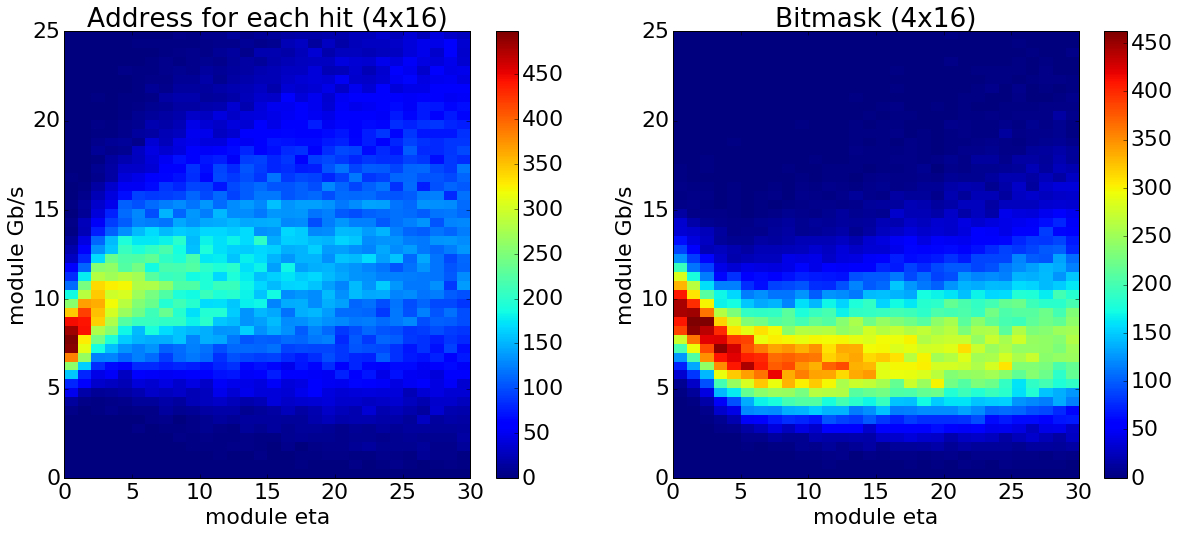

In [73]:
plt.figure(figsize=(20, 8))
algs = ['base', 'bitmask']
region_alg_labels = {
    'base': 'Address for each hit', 
    #'region': 'Address for each region + list pixels within region (include zeros)',
    'region': 'Simple region',
    #'zrle': 'Address for each region + list pixels within region (ZRLE)',
    'zrle': 'ZRLE',
    #'line': 'Address for each region + list pixels within region (ZRLE + Line prediction)',
    'line': 'Line template',
    #'lzw': 'Address for each region + list pixels within region (LZW)',
    'lzw': 'LZW',
    'lzw_cds': 'Address for each region + list pixels within region (LZW with constant dictionary size)',
    #'bitmask': 'Address for each region + list non-zero pixels with + bitmask',
    'bitmask': 'Bitmask',
    'single_hit': 'Address for each hit + number of hits within region',
    'optimal': 'The best option'
}

for i, alg in enumerate(algs):
    plt.subplot(1, 2, i + 1)
    bits_sizes = np.array(compression_region_variation[alg])[:, 1]/1000.0
    etas = np.array(compression_region_variation[alg])[:, 0]
    print np.mean(bits_sizes), np.std(bits_sizes)
    H, yedges, xedges = np.histogram2d(bits_sizes, etas, bins=(np.linspace(0, 25, 51), range(0, 31)))
    plt.imshow(H, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')
    plt.ylabel('module Gb/s')
    plt.xlabel('module eta')
    plt.title(region_alg_labels[alg] + ' (' + str(NX) + 'x' + str(NY) + ')')
plt.savefig('total_region_' + str(NX) + 'x' + str(NY) + '_bits_per_eta.png')

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


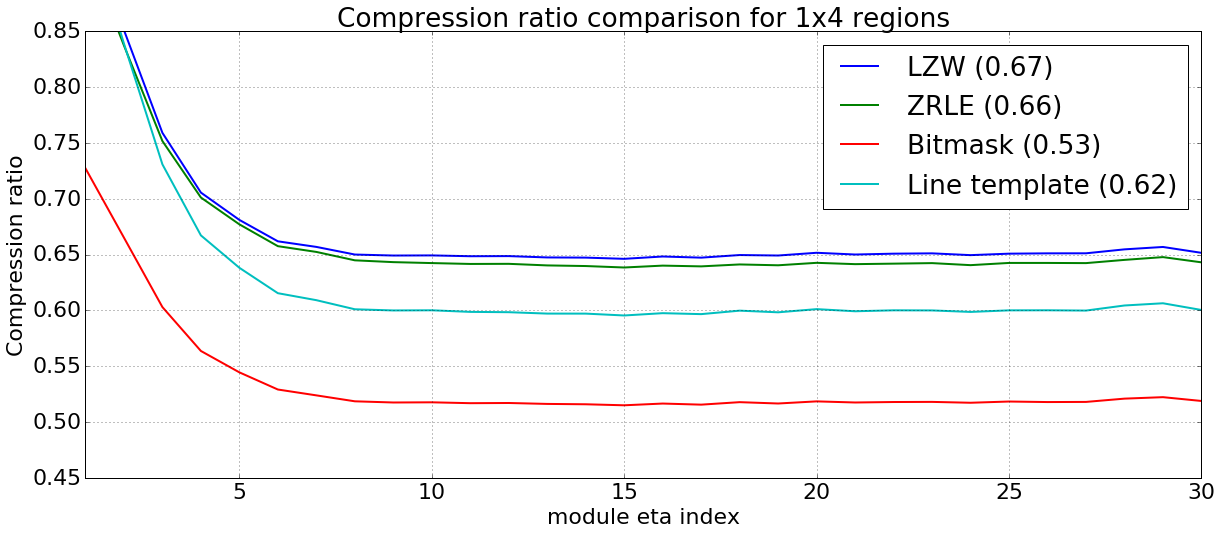

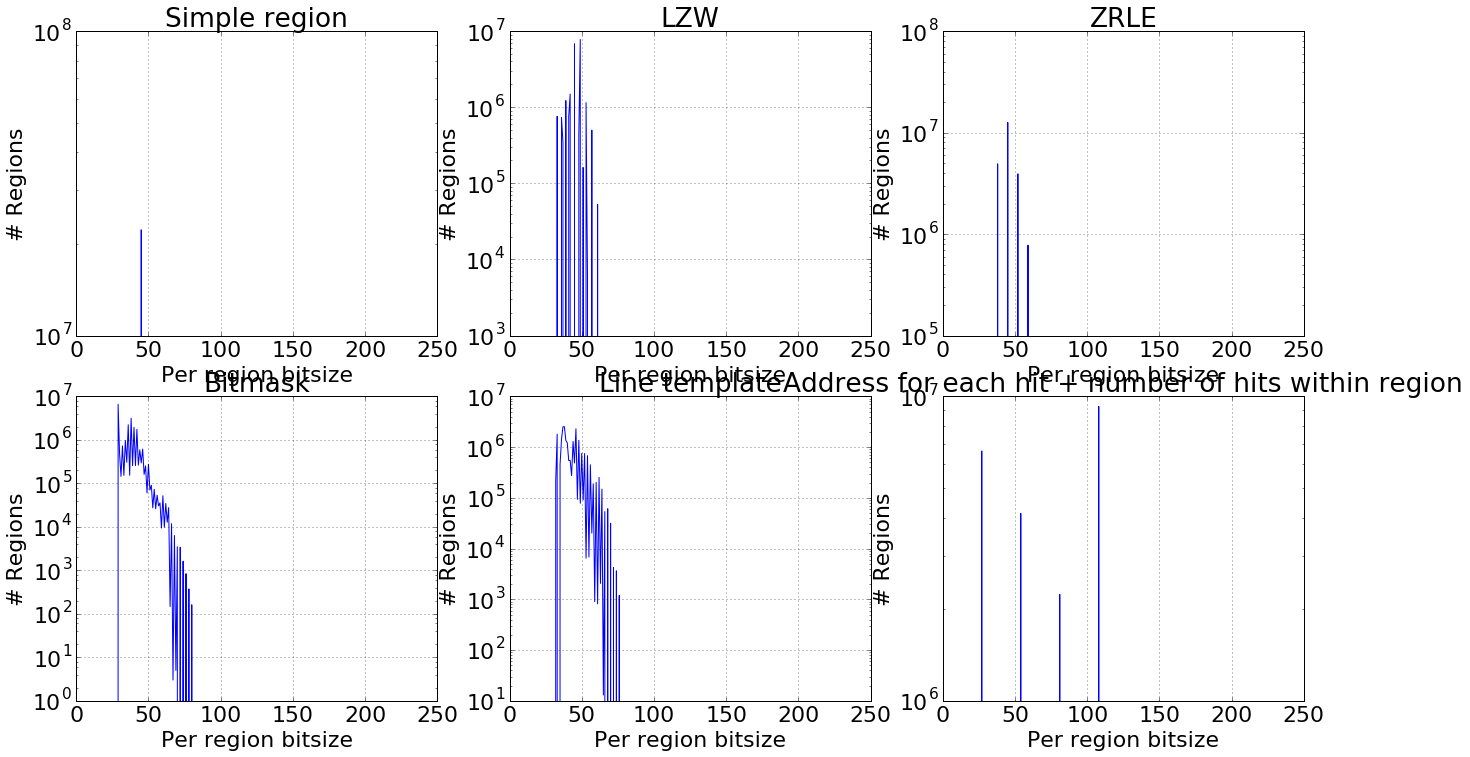

In [66]:
NX = 1
NY = 4
algs = ['base', 'region', 'lzw', 'zrle', 'bitmask', 'single_hit', 'line']

region_compression_bits = {}
region_compression_bit_counts = {}
region_compression_bit_histograms = {}
for alg in algs:
    region_compression_bits[alg] = [0 for x in range(0, 31)]
    region_compression_bit_counts[alg] = [0 for x in range(0, 31)]
    region_compression_bit_histograms[alg] = np.zeros((240))

for eta_i in range(1, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        for alg in algs:
            bit_sizes = get_region_bit_sizes_for_alg(eta_i, phi_i, alg, NX, NY)
            hist, _ = np.histogram(bit_sizes, bins=range(0, 241, 1))
            region_compression_bit_histograms[alg] += hist
            region_compression_bits[alg][eta_i] += bit_sizes.sum()
            region_compression_bit_counts[alg][eta_i] += len(bit_sizes)
    print

algs = ['lzw', 'zrle', 'bitmask', 'line']    

plt.figure(figsize=(20,8))
for alg in (algs):
    overall_ratio = round(1.0 * np.sum(region_compression_bits[alg]) / np.sum(region_compression_bits['base'])*100)/100
    plt.plot(1.0 * np.array(region_compression_bits[alg]) / np.array(region_compression_bits['base']), linewidth=2, label=region_alg_labels[alg] + ' (' + str(overall_ratio) + ')')
plt.legend()
plt.xlim([1, 30])
plt.ylim([0.45, 0.85])
plt.xlabel('module eta index')
plt.grid(True)
plt.title('Compression ratio comparison for ' + str(NX) + 'x' + str(NY) + ' regions')
plt.ylabel('Compression ratio')
plt.savefig('region_' + str(NX) + 'x' + str(NY) + '_compression_ratio.png')

algs = ['region', 'lzw', 'zrle', 'bitmask', 'line', 'single_hit']

plt.figure(figsize=(22,12))
for i, alg in enumerate(algs):
    plt.subplot(2, 3, i + 1)
    plt.plot(range(0, 240, 1), region_compression_bit_histograms[alg])
    plt.title(region_alg_labels[alg])
    #plt.xlim([1, 30])
    #plt.ylim([0, 10**6])
    plt.xlabel('Per region bitsize')
    plt.grid(True)
    plt.yscale('log')
    plt.ylabel('# Regions')
plt.savefig('region_' + str(NX) + 'x' + str(NY) + '_size_distribution.png')

In [83]:
def get_sorted_chain(regions_for_event, positions, nx, ny):    
    sorted_regions_for_event = []
    index = 0
    for i, (x1, y1, x2, y2) in enumerate(positions):
        regions_for_cluster = regions_for_event[i]
        for region, rx, ry in regions_for_cluster:
            x = (x1 + rx) / nx * nx
            y = (y1 + ry) / ny * ny
            sorted_regions_for_event += [(index, x, y)]
            index += 1

    sorted_regions_for_event = np.array(sorted(sorted_regions_for_event, key=lambda r: r[1]*336 + r[2]))

    dx = (sorted_regions_for_event[1:, 1] - sorted_regions_for_event[:-1, 1])/nx
    dy = (sorted_regions_for_event[1:, 2] - sorted_regions_for_event[:-1, 2])/ny
    dl = dx * int(ceil((810.0/ny))) + dy

    chain = np.c_[sorted_regions_for_event[:-1, 0], sorted_regions_for_event[1:, 0], dl.T]
    sorted_chain = np.array(sorted(chain, key=lambda c: c[0]))[:, 1:]
    return sorted_chain

def region_chain_path_and_filename(eta, phi, x, y):
    region_size = str(x) + 'x' + str(y)
    return ('data/chains/' + region_size + '/' + str(eta) + '/', str(phi) + '.dat')

def load_region_chains(eta, phi, x, y):
    path, filename = region_chain_path_and_filename(eta, phi, x, y)
    if not os.path.exists(path):
        os.makedirs(path)
    
    chains = {}
    
    regions = get_regions(eta, phi, x, y)
    cl_positions = cluster_positions(eta, phi)

    for eventID, regions_for_event in regions.iteritems():
        chains[eventID] = get_sorted_chain(regions_for_event, cl_positions[eventID], x, y)

    outfile = open(path + filename, 'wb')
    cPickle.dump(chains, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    outfile.close()
    return chains
        
def get_region_chains(eta, phi, x, y, force_reload=False):
    path, filename = region_chain_path_and_filename(eta, phi, x, y)
    if force_reload or not os.path.exists(path + filename):
        return load_region_chains(eta, phi, x, y)
    else:
        infile = open(path + filename, 'r')
        data = cPickle.load(infile)
        infile.close
        return data

In [247]:
NX = 2
NY = 8

for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        get_region_chains(eta_i, phi_i, NX, NY, force_reload=True)
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

In [66]:
NX = 2
NY = 8

delta_histogram = np.zeros((10000))

for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,
        module_chain = get_region_chains(eta_i, phi_i, NX, NY)
        for eventID, region_chain in module_chain.iteritems():
            hist, _ = np.histogram(region_chain[:, 1], bins=range(10001))
            delta_histogram += hist
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

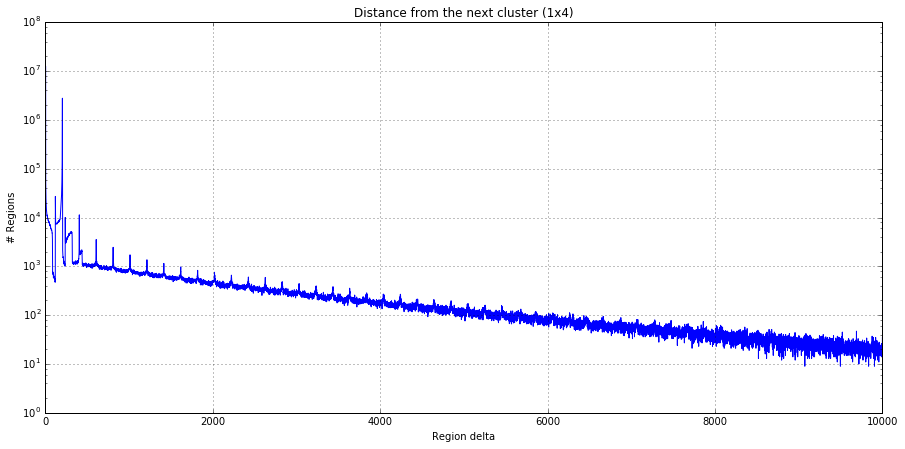

In [272]:
plt.figure(figsize=(15,7))
plt.plot(delta_histogram)
plt.title('Distance from the next cluster (' + str(NX) + 'x' + str(NY) + ')')
#plt.xlim([0, 1000])
#plt.ylim([0, 10**6])
plt.xlabel('Region delta')
plt.grid(True)
plt.yscale('log')
plt.ylabel('# Regions')
plt.savefig('region_' + str(NX) + 'x' + str(NY) + '_delta_distribution.png')

In [67]:
from heapq import heappush, heappop, heapify

def huffman_codes(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in enumerate(symb2freq)]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

delta_histogram[0] = 0
huff = huffman_codes(delta_histogram)
np.save('data/region_huffman' + str(NX) + 'x' + str(NY) + '.npy', np.array(huff))

In [88]:
from itertools import chain

NX = 1
NY = 4

huffman_codes = np.load('data/region_huffman' + str(NX) + 'x' + str(NY) + '.npy')
huffman_dict = {}

for delta, huffman_code in huffman_codes:
    huffman_dict[int(delta)] = huffman_code

def huffman_delta_size(delta):
    if delta in huffman_dict:
        return len(huffman_dict[delta])
    else:
        return 10**10
    
def chain_event_bit_size(regions_for_event, event_chain, nx, ny, size_limit):
    event_bit_size = 0

    current_region = np.zeros((nx, ny))
    current_index = 0
    current_bit_size = 0
    previous_delta = 0
    while current_index < len(event_chain):
        region, _, _ = regions_for_event[current_index]
        current_region += region

        next_index, delta = event_chain[current_index]
        #print current_index, delta,

        if delta > 0:
            bit_size = bitmask_region_bit_length(current_region, eventID)
            additional_address_size = 0
            if current_bit_size > 0:
                additional_address_size += huffman_delta_size(previous_delta) - region_address_size(current_region)

            if current_bit_size + bit_size + additional_address_size < size_limit and additional_address_size <= 0:
                #print additional_address_size, 'add'
                current_bit_size += bit_size + additional_address_size
            else:
                #print current_bit_size, bit_size + additional_address_size, 'stop'
                event_bit_size += current_bit_size
                current_bit_size = bit_size

            current_region = np.zeros((nx, ny))
        current_index = next_index
        previous_delta = delta
    event_bit_size += current_bit_size
    return event_bit_size

compression_chained_region_variation = []
size_limit = 0

for eta_i in range(0, 31):
    print 'eta:', eta_i, 'phi:',
    for phi_i in range(0,16):
        print phi_i,

        regions = get_regions(eta_i, phi_i, NX, NY)
        module_chains = get_region_chains(eta_i, phi_i, NX, NY)
        for eventID, event_regions in regions.iteritems():
            flat_event_regions = list(chain.from_iterable(event_regions))
            event_chain = module_chains[eventID]

            event_bit_size = chain_event_bit_size(flat_event_regions, event_chain, NX, NY, size_limit)
            compression_chained_region_variation += [(eta_i, event_bit_size)]
    print

eta: 0 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12

In [89]:
np.save('data/total_chained_region_event_bit_sizes_' + str(size_limit) + '_' + str(NX) + 'x' + str(NY) + '.npy', compression_chained_region_variation)

6.56770520833 2.59979582647


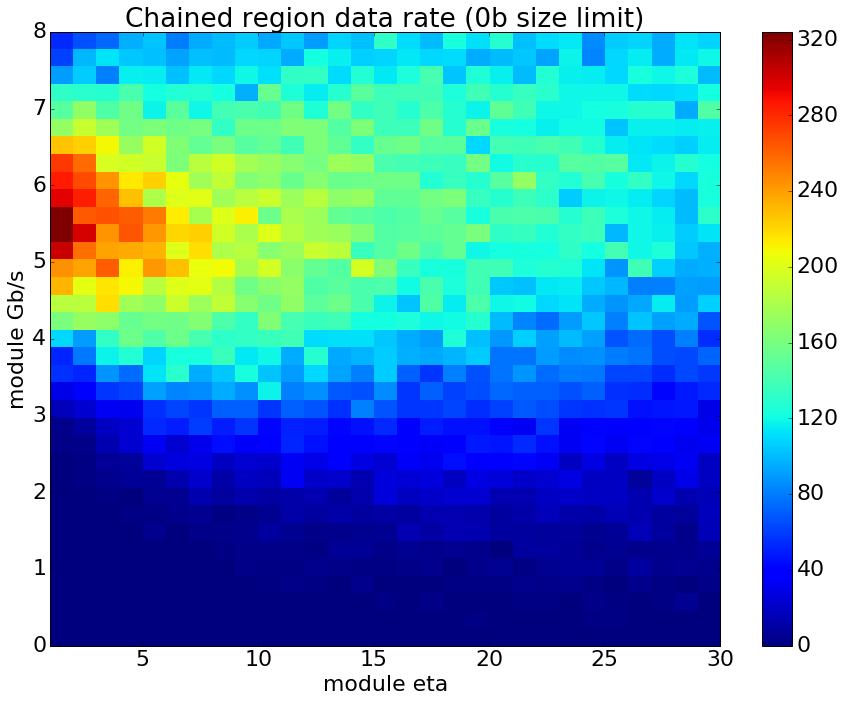

In [90]:
plt.figure(figsize=(15, 11))

size_limit = 0
NX = 1
NY = 4
compression_chained_region_variation = np.load('data/total_chained_region_event_bit_sizes_' + str(size_limit) + '_' + str(NX) + 'x' + str(NY) + '.npy')

bits_sizes = np.array(compression_chained_region_variation)[:, 1]/1000.0
etas = np.array(compression_chained_region_variation)[:, 0] - 0.1
print np.mean(bits_sizes), np.std(bits_sizes)
H, yedges, xedges = np.histogram2d(bits_sizes, etas, bins=(np.linspace(0, 8, 36), range(1, 31)))
plt.imshow(H, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.axis('tight')
plt.ylabel('module Gb/s')
plt.xlabel('module eta')
plt.title('Chained region data rate (' + str(size_limit) + 'b size limit)')
plt.savefig('total_chained_region_' + str(size_limit) + '_' + str(NX) + 'x' + str(NY) + '_bits_per_eta.png')

In [78]:
# TODOs:
# More 'realistic scenarios'
#    1x4 regions - 32bits- compare Huffman and line prediction with bitmask - ask how the Huffman works here
#    2x8 regions - the same thing

# Look at some lossy compression methods and figure out what would be the compression ratio if lossiness was minimized

# Find shortest region chain for each event
# Find what is the ratio of clusters plit by regions
# How many clusters can you fit into 64 bit packet (128)

# - Produce plot which shows data rate variation for each eta

3.16992500144
